<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Practice day #2: ES models

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Info</h1> 

This practice task is desinged for impriving knowledge of ARIMA models and getting aqcuainted with statistical time series analysis in python.

The task should take about 3-5 hours to be completed.

<h1 align="center">1. Reading data (5%)</h1>

  * Download data for following data sets
     - 1) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv </span>(1 TS of monthly wage in Russia)
     - 2) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">energy_cunsumption.csv</span> (105 TS of goods sales in shop #36 of one real Retail Net, each TS correspond to an item in shop )
 
 All data you can find by <a href='https://1drv.ms/f/s!AqGgzb5T4tvShZ5by4qa_HFqAAoYIg'>link</a> 
 
 
 * For each data set: 
      - 1) learn it's structure in csv-file and read it into Pandas data frame (be careful with parsing data)
      - 2) plot each time series
      - 3) answer the questions: is there seasonlaity, trend, changes in level in TS? If there is seasonality then define period of seasonality. 

C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



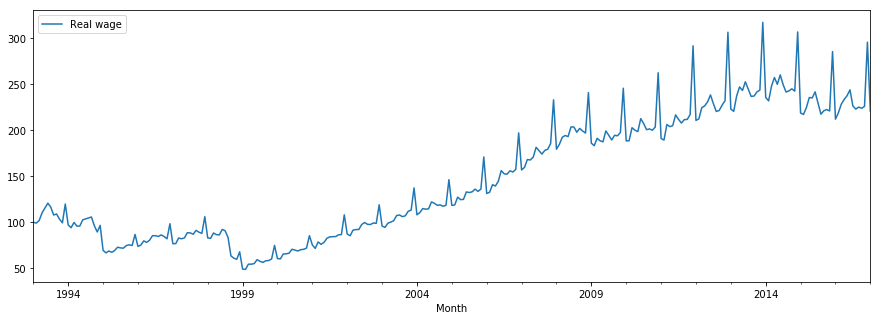

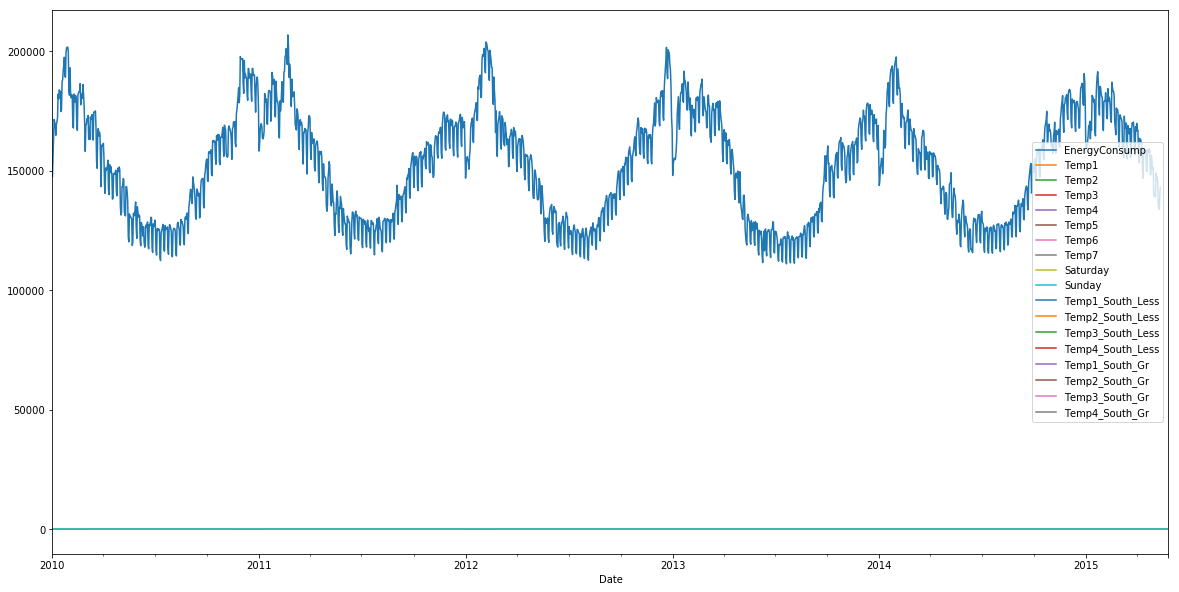

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
import math
import pandas.tseries.offsets as ofs
import warnings as w
from matplotlib import gridspec
import plotly.plotly as py
from scipy import stats
from IPython.display import Image

import statsmodels.api as sm

%matplotlib inline


ts = pd.read_csv('monthly-wage.csv', sep=';', decimal='.', index_col='Month', parse_dates=True, dayfirst=True)
ts_en = pd.read_csv('energy_consump.csv', decimal= '.', sep=',',parse_dates=True, dayfirst=False, index_col='Date')
ts.plot(figsize=(15,5))
ts_en.plot(figsize=(20,10))

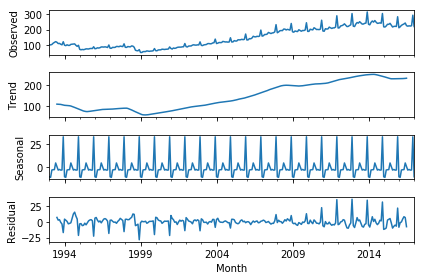

In [2]:
res = sm.tsa.seasonal_decompose(ts)
resplot = res.plot()

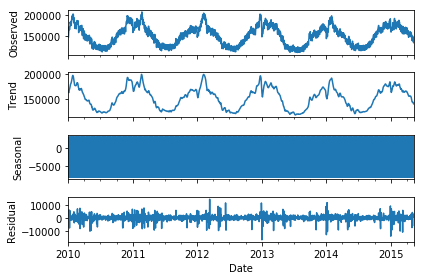

In [3]:
res = sm.tsa.seasonal_decompose(ts_en['EnergyConsump'].dropna(axis=0))
resplot = res.plot()

<h1 align="center">2. ARIMA Model for wage dataset (40%) </h1>
You need to analyseTS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span> in accordance with forecasting scheme (see lecture slide Scheme of TS forecasting with ARIMA) and then build forecast.

**I. Select ARIMA parameters your self ** 
Also you can follow the next scheme:
<img src='./pic/ARMA Scheme.png'>


Notes: you need follow to the steps
 * 0) Use data before 01.02.2015 
 * 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
 * 2) Dispersion is stabilized through transformation if needed.
 * 3) If the time series is non-stationary the differentiation degrees is
chosen.
 * 4) ACF/PACF are analyzed in order to understand whether AR(p)/MA(q) and seasonal $AR(P)/MA(Q)$  may be used.
 * 5) Candidate models are trained, their AIC/AIC is compared, choose trhe best model.
 * 6) Unbiasedness, stationarity and non-autocorrelation of the residuals of the obtained model are tested; if the tests fail model modifcations are reviewed.
 * 7) Build forecasts and forecastis interval for period from 01.02.2015 to 01.01.2017
     Calculate loss MACAPE of your Forecast.
     Does the forecast look like appropriate?

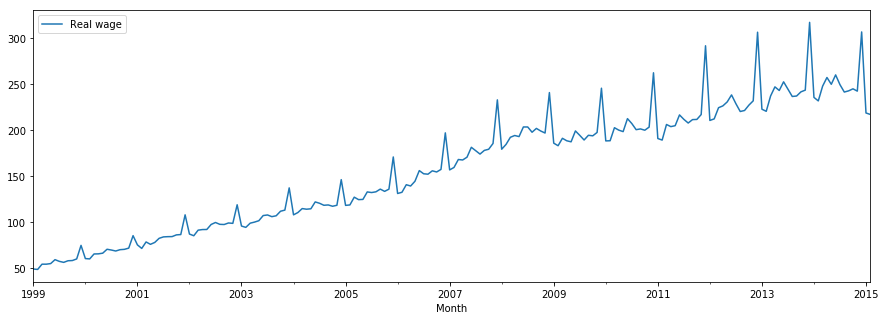

In [4]:
#0)1)
ts1=ts.loc['1999.01.01':'2015-02-01']
ts1.plot(figsize=(15,5))

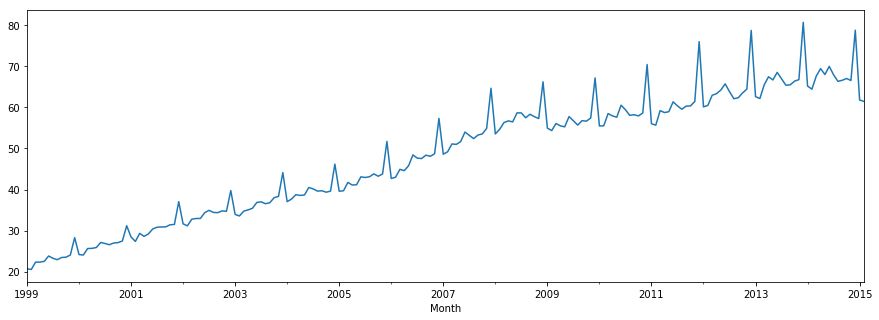

In [5]:
#2)
from copy import deepcopy
ts1_boxcox = deepcopy(ts1)
ts1_boxcox['wage_boxcox'] = stats.boxcox(ts1)[0]
ts1_boxcox['wage_boxcox'].plot(figsize=(15,5))

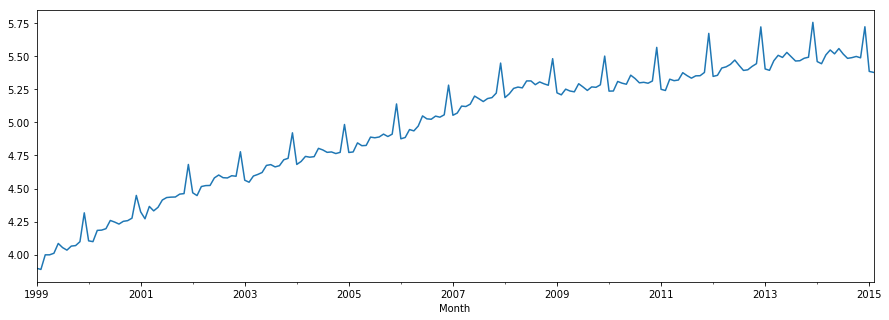

In [6]:
ts1_boxcox['wage_boxcox'] = np.log(ts1)
ts1_boxcox['wage_boxcox'].plot(figsize=(15,5))

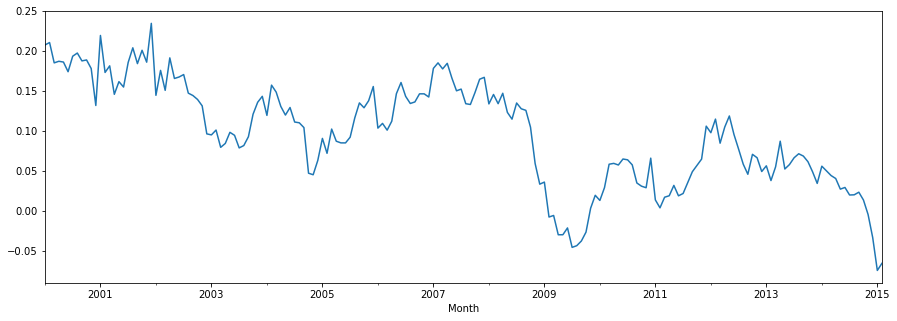

In [7]:
#3)
p = 12
sdiff_ts1_boxcox = (ts1_boxcox['wage_boxcox'] - ts1_boxcox['wage_boxcox'].shift(p))[p:]
sdiff_ts1_boxcox.plot(figsize=(15,5))

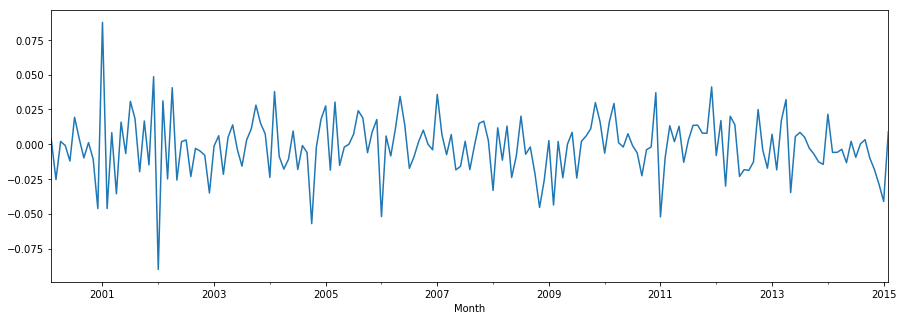

In [8]:
diff_sdiff_ts1_boxcox = (sdiff_ts1_boxcox  - sdiff_ts1_boxcox .shift(1))[1:]
diff_sdiff_ts1_boxcox.plot(figsize=(15,5))

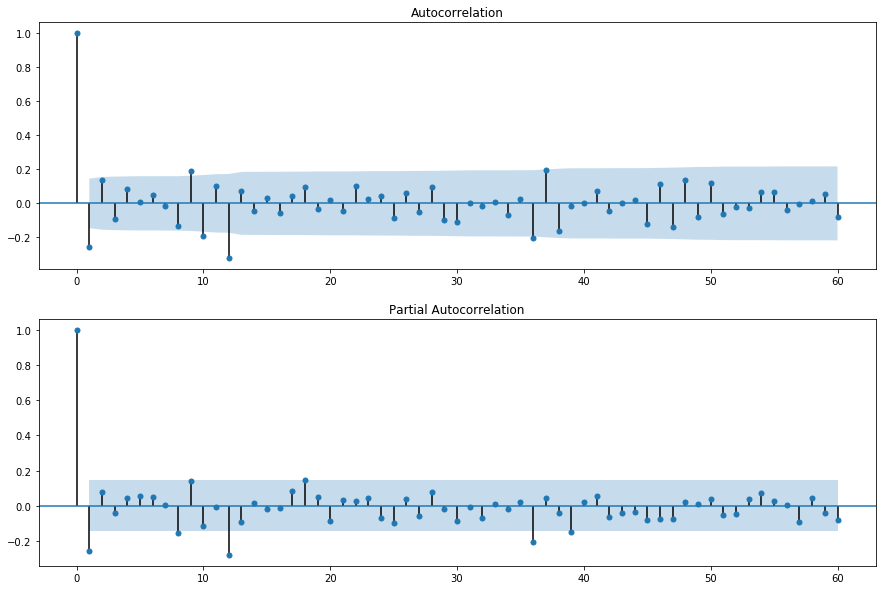

In [9]:
#4)
ts2 = diff_sdiff_ts1_boxcox
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts2.values.squeeze(), lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts2.values.squeeze(), lags=60, ax=ax2)

5) So we have to chose $p\in\{1,8,9,10\}$, $q\in\{1,9,10\}$ and $P,Q\in\{1,3\}$.

In [10]:
from statsmodels.tsa import stattools
stat= stattools.kpss(np.array(ts2))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.069927, 
pvalue: 0.10 
maximal Lag: 14 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



In [24]:
mod = sm.tsa.statespace.SARIMAX(ts1, trend='n', order=(1,1,1), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          Real wage   No. Observations:                  194
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -490.332
Date:                            Wed, 07 Jun 2017   AIC                            990.663
Time:                                    12:48:20   BIC                           1007.002
Sample:                                01-01-1999   HQIC                           997.279
                                     - 02-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4005      0.518     -0.773      0.439      -1.416       0.615
ma.L1          0.2597      0.522   

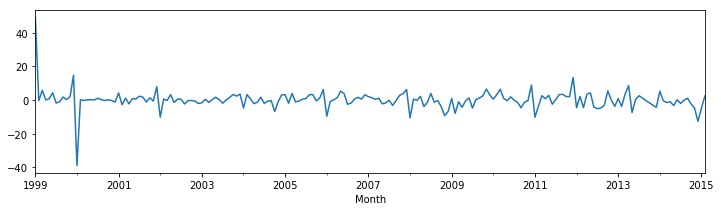

In [26]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax = results.resid.plot(ax=ax);

In [27]:
# Darbin_Watson statistic
sm.stats.durbin_watson(results.resid.values)

1.8091153739216914

In [28]:
stat = stats.wilcoxon(results.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat[0],stat[1]))

Statistic: 9276.000000
pvalue: 0.82


In [29]:
# Normal test
resid = results.resid
stats.normaltest(resid)

NormaltestResult(statistic=126.77188907700727, pvalue=2.9636987481133572e-28)

In [31]:
from statsmodels.tsa import stattools
stat= stattools.kpss(np.array(results.resid))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.240141, 
pvalue: 0.10 
maximal Lag: 15 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



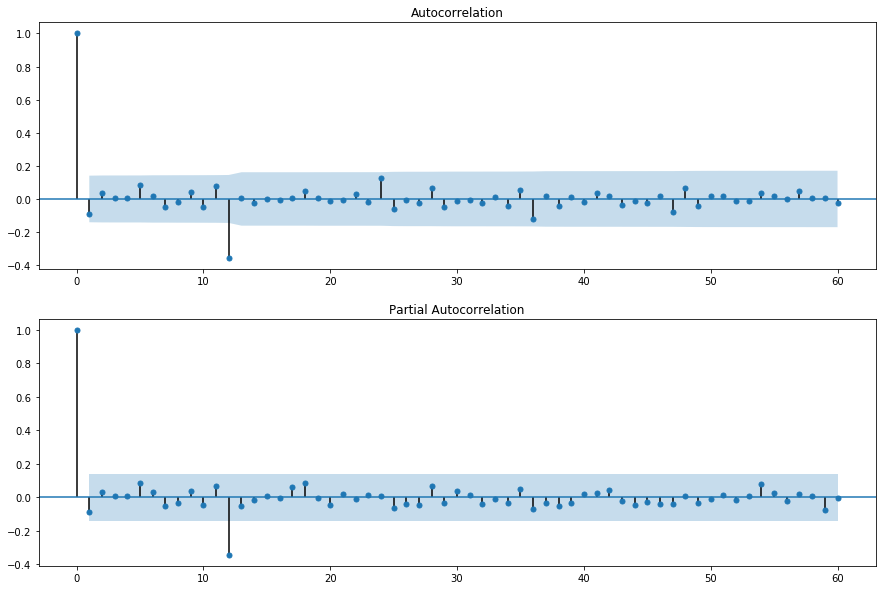

In [32]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid.values.squeeze(), lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid.values.squeeze(), lags=60, ax=ax2)

In [35]:
frc_sarimax = results.predict('2015-01-01', '2017-01-01', dynamic=False)
print(frc_sarimax)

2015-01-01    223.282396
2015-02-01    214.577277
2015-03-01    233.041618
2015-04-01    243.030881
2015-05-01    235.188224
2015-06-01    245.684670
2015-07-01    234.658431
2015-08-01    226.336607
2015-09-01    227.612321
2015-10-01    229.906348
2015-11-01    227.198876
2015-12-01    293.702480
2016-01-01    202.352942
2016-02-01    200.699543
2016-03-01    217.309638
2016-04-01    227.756571
2016-05-01    219.524179
2016-06-01    230.295749
2016-07-01    218.852133
2016-08-01    210.205450
2016-09-01    211.458254
2016-10-01    213.845670
2016-11-01    210.931158
2016-12-01    279.735873
2017-01-01    184.940435
Freq: MS, dtype: float64


In [26]:
def qualityMACAPE(x,y):
    
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

In [43]:
frc_sarimax = frc_sarimax.to_frame(name='Real wage')

In [46]:
 qualityMACAPE(frc_sarimax, ts.loc['01.01.2015':'01.01.2017'])[0]

Real wage    0.045495
dtype: float64

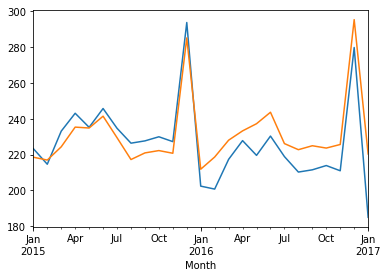

In [47]:
frc_sarimax['Real wage'].loc['01.01.2015':'01.01.2017'].plot(label='predict')
ts['Real wage'].loc['01.01.2015':'01.01.2017'].plot(label='m_wage')

Our forecast is a good one.

**II. Find the best parameters of ARIMA automaticaly** 
* 0) Use data before 01.02.2015 
* 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
* 2) Run grid search for ARIMA parameters (at least for 3 distinct values for $p,q,d, P, Q, D$). 
How many time does it take?
* 4) Find the best set of parameters according to AIC.
* 5) Build the forecast of the best model and it's forecasting interval for period from 01.02.2015 to 01.01.2017.
* 6) Calculate locc MACAPE of your forecast.

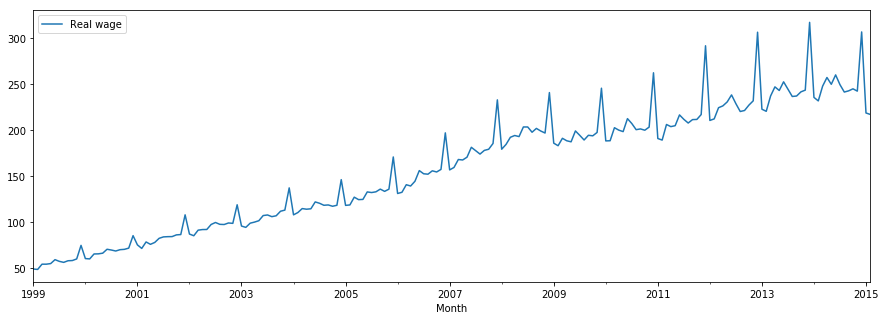

In [48]:
#0)1)
ts1=ts.loc['1999.01.01':'2015-02-01']
ts1.plot(figsize=(15,5))

In [80]:
%time
PQ_values=[1,2,3]
p_values=[1,8,9,10]
q_values=[1,9,10]
Dd_values=[0,1,2]
min_aic=1000
for P in PQ_values:
    for Q in PQ_values:
        for p in p_values:
            for q in q_values:
                for d in Dd_values:
                    for D in Dd_values:
                        print('model '+str((p,d,q,P,D,Q)))
                        try:
                            mod = sm.tsa.statespace.SARIMAX(ts1, trend='n', order=(p,d,q), seasonal_order=(P,D,Q,12))
                            results = mod.fit()
                        except Exception:
                            continue
                        if results.aic==np.NaN:
                            continue
                        if results.aic<min_aic:
                            min_aic=results.aic
                            model_min_aic=[p,d,q,P,D,Q]
                
                                
                

Wall time: 0 ns
model (1, 0, 1, 1, 0, 1)
model (1, 0, 1, 1, 1, 1)
model (1, 0, 1, 1, 2, 1)
model (1, 1, 1, 1, 0, 1)
model (1, 1, 1, 1, 1, 1)
model (1, 1, 1, 1, 2, 1)
model (1, 2, 1, 1, 0, 1)
model (1, 2, 1, 1, 1, 1)
model (1, 2, 1, 1, 2, 1)
model (1, 0, 9, 1, 0, 1)
model (1, 0, 9, 1, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 9, 1, 2, 1)
model (1, 1, 9, 1, 0, 1)
model (1, 1, 9, 1, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\tools.py:405: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 9, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 1, 0, 1)
model (1, 2, 9, 1, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 10, 1, 0, 1)
model (1, 0, 10, 1, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 10, 1, 2, 1)
model (1, 1, 10, 1, 0, 1)
model (1, 1, 10, 1, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 10, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 10, 1, 0, 1)
model (1, 2, 10, 1, 1, 1)
model (1, 2, 10, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 1, 1, 0, 1)
model (8, 0, 1, 1, 1, 1)
model (8, 0, 1, 1, 2, 1)
model (8, 1, 1, 1, 0, 1)
model (8, 1, 1, 1, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 1, 1, 1, 2, 1)
model (8, 2, 1, 1, 0, 1)
model (8, 2, 1, 1, 1, 1)
model (8, 2, 1, 1, 2, 1)
model (8, 0, 9, 1, 0, 1)
model (8, 0, 9, 1, 1, 1)
model (8, 0, 9, 1, 2, 1)
model (8, 1, 9, 1, 0, 1)
model (8, 1, 9, 1, 1, 1)
model (8, 1, 9, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 9, 1, 0, 1)
model (8, 2, 9, 1, 1, 1)
model (8, 2, 9, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 10, 1, 0, 1)
model (8, 0, 10, 1, 1, 1)
model (8, 0, 10, 1, 2, 1)
model (8, 1, 10, 1, 0, 1)
model (8, 1, 10, 1, 1, 1)
model (8, 1, 10, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 10, 1, 0, 1)
model (8, 2, 10, 1, 1, 1)
model (8, 2, 10, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 1, 1, 0, 1)
model (9, 0, 1, 1, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 1, 1, 2, 1)
model (9, 1, 1, 1, 0, 1)
model (9, 1, 1, 1, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 1, 1, 1, 2, 1)
model (9, 2, 1, 1, 0, 1)
model (9, 2, 1, 1, 1, 1)
model (9, 2, 1, 1, 2, 1)
model (9, 0, 9, 1, 0, 1)
model (9, 0, 9, 1, 1, 1)
model (9, 0, 9, 1, 2, 1)
model (9, 1, 9, 1, 0, 1)
model (9, 1, 9, 1, 1, 1)
model (9, 1, 9, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 9, 1, 0, 1)
model (9, 2, 9, 1, 1, 1)
model (9, 2, 9, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 10, 1, 0, 1)
model (9, 0, 10, 1, 1, 1)
model (9, 0, 10, 1, 2, 1)
model (9, 1, 10, 1, 0, 1)
model (9, 1, 10, 1, 1, 1)
model (9, 1, 10, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 10, 1, 0, 1)
model (9, 2, 10, 1, 1, 1)
model (9, 2, 10, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 1, 1, 0, 1)
model (10, 0, 1, 1, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 1, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 1, 1, 1, 0, 1)
model (10, 1, 1, 1, 1, 1)
model (10, 1, 1, 1, 2, 1)
model (10, 2, 1, 1, 0, 1)
model (10, 2, 1, 1, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 1, 1, 2, 1)
model (10, 0, 9, 1, 0, 1)
model (10, 0, 9, 1, 1, 1)
model (10, 0, 9, 1, 2, 1)
model (10, 1, 9, 1, 0, 1)
model (10, 1, 9, 1, 1, 1)
model (10, 1, 9, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 9, 1, 0, 1)
model (10, 2, 9, 1, 1, 1)
model (10, 2, 9, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 10, 1, 0, 1)
model (10, 0, 10, 1, 1, 1)
model (10, 0, 10, 1, 2, 1)
model (10, 1, 10, 1, 0, 1)
model (10, 1, 10, 1, 1, 1)
model (10, 1, 10, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 10, 1, 0, 1)
model (10, 2, 10, 1, 1, 1)
model (10, 2, 10, 1, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 1, 1, 0, 2)
model (1, 0, 1, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 1, 1, 2, 2)
model (1, 1, 1, 1, 0, 2)
model (1, 1, 1, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 1, 1, 2, 2)
model (1, 2, 1, 1, 0, 2)
model (1, 2, 1, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 1, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 9, 1, 0, 2)
model (1, 0, 9, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 9, 1, 2, 2)
model (1, 1, 9, 1, 0, 2)
model (1, 1, 9, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 9, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 1, 0, 2)
model (1, 2, 9, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 10, 1, 0, 2)
model (1, 0, 10, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 10, 1, 2, 2)
model (1, 1, 10, 1, 0, 2)
model (1, 1, 10, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 10, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 10, 1, 0, 2)
model (1, 2, 10, 1, 1, 2)
model (1, 2, 10, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 1, 1, 0, 2)
model (8, 0, 1, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 1, 1, 2, 2)
model (8, 1, 1, 1, 0, 2)
model (8, 1, 1, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 1, 1, 1, 2, 2)
model (8, 2, 1, 1, 0, 2)
model (8, 2, 1, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 1, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 9, 1, 0, 2)
model (8, 0, 9, 1, 1, 2)
model (8, 0, 9, 1, 2, 2)
model (8, 1, 9, 1, 0, 2)
model (8, 1, 9, 1, 1, 2)
model (8, 1, 9, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 9, 1, 0, 2)
model (8, 2, 9, 1, 1, 2)
model (8, 2, 9, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 10, 1, 0, 2)
model (8, 0, 10, 1, 1, 2)
model (8, 0, 10, 1, 2, 2)
model (8, 1, 10, 1, 0, 2)
model (8, 1, 10, 1, 1, 2)
model (8, 1, 10, 1, 2, 2)

C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




model (8, 2, 10, 1, 0, 2)
model (8, 2, 10, 1, 1, 2)
model (8, 2, 10, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 1, 1, 0, 2)
model (9, 0, 1, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 1, 1, 2, 2)
model (9, 1, 1, 1, 0, 2)
model (9, 1, 1, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 1, 1, 1, 2, 2)
model (9, 2, 1, 1, 0, 2)
model (9, 2, 1, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 1, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 9, 1, 0, 2)
model (9, 0, 9, 1, 1, 2)
model (9, 0, 9, 1, 2, 2)
model (9, 1, 9, 1, 0, 2)
model (9, 1, 9, 1, 1, 2)
model (9, 1, 9, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 9, 1, 0, 2)
model (9, 2, 9, 1, 1, 2)
model (9, 2, 9, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 10, 1, 0, 2)
model (9, 0, 10, 1, 1, 2)
model (9, 0, 10, 1, 2, 2)
model (9, 1, 10, 1, 0, 2)
model (9, 1, 10, 1, 1, 2)
model (9, 1, 10, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 10, 1, 0, 2)
model (9, 2, 10, 1, 1, 2)
model (9, 2, 10, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 1, 1, 0, 2)
model (10, 0, 1, 1, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 1, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 1, 1, 1, 0, 2)
model (10, 1, 1, 1, 1, 2)
model (10, 1, 1, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 1, 1, 0, 2)
model (10, 2, 1, 1, 1, 2)
model (10, 2, 1, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 9, 1, 0, 2)
model (10, 0, 9, 1, 1, 2)
model (10, 0, 9, 1, 2, 2)
model (10, 1, 9, 1, 0, 2)
model (10, 1, 9, 1, 1, 2)
model (10, 1, 9, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 9, 1, 0, 2)
model (10, 2, 9, 1, 1, 2)
model (10, 2, 9, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 10, 1, 0, 2)
model (10, 0, 10, 1, 1, 2)
model (10, 0, 10, 1, 2, 2)
model (10, 1, 10, 1, 0, 2)
model (10, 1, 10, 1, 1, 2)
model (10, 1, 10, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 10, 1, 0, 2)
model (10, 2, 10, 1, 1, 2)
model (10, 2, 10, 1, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 1, 1, 0, 3)
model (1, 0, 1, 1, 1, 3)
model (1, 0, 1, 1, 2, 3)
model (1, 1, 1, 1, 0, 3)
model (1, 1, 1, 1, 1, 3)
model (1, 1, 1, 1, 2, 3)
model (1, 2, 1, 1, 0, 3)
model (1, 2, 1, 1, 1, 3)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 1, 1, 2, 3)
model (1, 0, 9, 1, 0, 3)
model (1, 0, 9, 1, 1, 3)
model (1, 0, 9, 1, 2, 3)
model (1, 1, 9, 1, 0, 3)
model (1, 1, 9, 1, 1, 3)
model (1, 1, 9, 1, 2, 3)
model (1, 2, 9, 1, 0, 3)
model (1, 2, 9, 1, 1, 3)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 1, 2, 3)
model (1, 0, 10, 1, 0, 3)
model (1, 0, 10, 1, 1, 3)
model (1, 0, 10, 1, 2, 3)
model (1, 1, 10, 1, 0, 3)
model (1, 1, 10, 1, 1, 3)
model (1, 1, 10, 1, 2, 3)
model (1, 2, 10, 1, 0, 3)
model (1, 2, 10, 1, 1, 3)
model (1, 2, 10, 1, 2, 3)
model (8, 0, 1, 1, 0, 3)
model (8, 0, 1, 1, 1, 3)
model (8, 0, 1, 1, 2, 3)
model (8, 1, 1, 1, 0, 3)
model (8, 1, 1, 1, 1, 3)
model (8, 1, 1, 1, 2, 3)
model (8, 2, 1, 1, 0, 3)
model (8, 2, 1, 1, 1, 3)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 1, 1, 2, 3)
model (8, 0, 9, 1, 0, 3)
model (8, 0, 9, 1, 1, 3)
model (8, 0, 9, 1, 2, 3)
model (8, 1, 9, 1, 0, 3)
model (8, 1, 9, 1, 1, 3)
model (8, 1, 9, 1, 2, 3)
model (8, 2, 9, 1, 0, 3)
model (8, 2, 9, 1, 1, 3)
model (8, 2, 9, 1, 2, 3)
model (8, 0, 10, 1, 0, 3)
model (8, 0, 10, 1, 1, 3)
model (8, 0, 10, 1, 2, 3)
model (8, 1, 10, 1, 0, 3)
model (8, 1, 10, 1, 1, 3)
model (8, 1, 10, 1, 2, 3)
model (8, 2, 10, 1, 0, 3)
model (8, 2, 10, 1, 1, 3)
model (8, 2, 10, 1, 2, 3)
model (9, 0, 1, 1, 0, 3)
model (9, 0, 1, 1, 1, 3)
model (9, 0, 1, 1, 2, 3)
model (9, 1, 1, 1, 0, 3)
model (9, 1, 1, 1, 1, 3)
model (9, 1, 1, 1, 2, 3)
model (9, 2, 1, 1, 0, 3)
model (9, 2, 1, 1, 1, 3)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 1, 1, 2, 3)
model (9, 0, 9, 1, 0, 3)
model (9, 0, 9, 1, 1, 3)
model (9, 0, 9, 1, 2, 3)
model (9, 1, 9, 1, 0, 3)
model (9, 1, 9, 1, 1, 3)
model (9, 1, 9, 1, 2, 3)
model (9, 2, 9, 1, 0, 3)
model (9, 2, 9, 1, 1, 3)
model (9, 2, 9, 1, 2, 3)
model (9, 0, 10, 1, 0, 3)
model (9, 0, 10, 1, 1, 3)
model (9, 0, 10, 1, 2, 3)
model (9, 1, 10, 1, 0, 3)
model (9, 1, 10, 1, 1, 3)
model (9, 1, 10, 1, 2, 3)
model (9, 2, 10, 1, 0, 3)
model (9, 2, 10, 1, 1, 3)
model (9, 2, 10, 1, 2, 3)
model (10, 0, 1, 1, 0, 3)
model (10, 0, 1, 1, 1, 3)
model (10, 0, 1, 1, 2, 3)
model (10, 1, 1, 1, 0, 3)
model (10, 1, 1, 1, 1, 3)
model (10, 1, 1, 1, 2, 3)
model (10, 2, 1, 1, 0, 3)
model (10, 2, 1, 1, 1, 3)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 1, 1, 2, 3)
model (10, 0, 9, 1, 0, 3)
model (10, 0, 9, 1, 1, 3)
model (10, 0, 9, 1, 2, 3)
model (10, 1, 9, 1, 0, 3)
model (10, 1, 9, 1, 1, 3)
model (10, 1, 9, 1, 2, 3)
model (10, 2, 9, 1, 0, 3)
model (10, 2, 9, 1, 1, 3)
model (10, 2, 9, 1, 2, 3)
model (10, 0, 10, 1, 0, 3)
model (10, 0, 10, 1, 1, 3)
model (10, 0, 10, 1, 2, 3)
model (10, 1, 10, 1, 0, 3)
model (10, 1, 10, 1, 1, 3)
model (10, 1, 10, 1, 2, 3)
model (10, 2, 10, 1, 0, 3)
model (10, 2, 10, 1, 1, 3)
model (10, 2, 10, 1, 2, 3)
model (1, 0, 1, 2, 0, 1)
model (1, 0, 1, 2, 1, 1)
model (1, 0, 1, 2, 2, 1)
model (1, 1, 1, 2, 0, 1)
model (1, 1, 1, 2, 1, 1)
model (1, 1, 1, 2, 2, 1)
model (1, 2, 1, 2, 0, 1)
model (1, 2, 1, 2, 1, 1)
model (1, 2, 1, 2, 2, 1)
model (1, 0, 9, 2, 0, 1)
model (1, 0, 9, 2, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 9, 2, 2, 1)
model (1, 1, 9, 2, 0, 1)
model (1, 1, 9, 2, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 9, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 2, 0, 1)
model (1, 2, 9, 2, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 10, 2, 0, 1)
model (1, 0, 10, 2, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 10, 2, 2, 1)
model (1, 1, 10, 2, 0, 1)
model (1, 1, 10, 2, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 10, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 10, 2, 0, 1)
model (1, 2, 10, 2, 1, 1)
model (1, 2, 10, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 1, 2, 0, 1)
model (8, 0, 1, 2, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 1, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 1, 1, 2, 0, 1)
model (8, 1, 1, 2, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 1, 1, 2, 2, 1)
model (8, 2, 1, 2, 0, 1)
model (8, 2, 1, 2, 1, 1)
model (8, 2, 1, 2, 2, 1)
model (8, 0, 9, 2, 0, 1)
model (8, 0, 9, 2, 1, 1)
model (8, 0, 9, 2, 2, 1)
model (8, 1, 9, 2, 0, 1)
model (8, 1, 9, 2, 1, 1)
model (8, 1, 9, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 9, 2, 0, 1)
model (8, 2, 9, 2, 1, 1)
model (8, 2, 9, 2, 2, 1)

C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




model (8, 0, 10, 2, 0, 1)
model (8, 0, 10, 2, 1, 1)
model (8, 0, 10, 2, 2, 1)
model (8, 1, 10, 2, 0, 1)
model (8, 1, 10, 2, 1, 1)
model (8, 1, 10, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 10, 2, 0, 1)
model (8, 2, 10, 2, 1, 1)
model (8, 2, 10, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 1, 2, 0, 1)
model (9, 0, 1, 2, 1, 1)
model (9, 0, 1, 2, 2, 1)
model (9, 1, 1, 2, 0, 1)
model (9, 1, 1, 2, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 1, 1, 2, 2, 1)
model (9, 2, 1, 2, 0, 1)
model (9, 2, 1, 2, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 1, 2, 2, 1)
model (9, 0, 9, 2, 0, 1)
model (9, 0, 9, 2, 1, 1)
model (9, 0, 9, 2, 2, 1)
model (9, 1, 9, 2, 0, 1)
model (9, 1, 9, 2, 1, 1)
model (9, 1, 9, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 9, 2, 0, 1)
model (9, 2, 9, 2, 1, 1)
model (9, 2, 9, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 10, 2, 0, 1)
model (9, 0, 10, 2, 1, 1)
model (9, 0, 10, 2, 2, 1)
model (9, 1, 10, 2, 0, 1)
model (9, 1, 10, 2, 1, 1)
model (9, 1, 10, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 10, 2, 0, 1)
model (9, 2, 10, 2, 1, 1)
model (9, 2, 10, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 1, 2, 0, 1)
model (10, 0, 1, 2, 1, 1)
model (10, 0, 1, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 1, 1, 2, 0, 1)
model (10, 1, 1, 2, 1, 1)
model (10, 1, 1, 2, 2, 1)
model (10, 2, 1, 2, 0, 1)
model (10, 2, 1, 2, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 1, 2, 2, 1)
model (10, 0, 9, 2, 0, 1)
model (10, 0, 9, 2, 1, 1)
model (10, 0, 9, 2, 2, 1)
model (10, 1, 9, 2, 0, 1)
model (10, 1, 9, 2, 1, 1)
model (10, 1, 9, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 9, 2, 0, 1)
model (10, 2, 9, 2, 1, 1)
model (10, 2, 9, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 10, 2, 0, 1)
model (10, 0, 10, 2, 1, 1)
model (10, 0, 10, 2, 2, 1)
model (10, 1, 10, 2, 0, 1)
model (10, 1, 10, 2, 1, 1)
model (10, 1, 10, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 10, 2, 0, 1)
model (10, 2, 10, 2, 1, 1)
model (10, 2, 10, 2, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 1, 2, 0, 2)
model (1, 0, 1, 2, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 1, 2, 2, 2)
model (1, 1, 1, 2, 0, 2)
model (1, 1, 1, 2, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 1, 2, 2, 2)
model (1, 2, 1, 2, 0, 2)
model (1, 2, 1, 2, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 1, 2, 2, 2)
model (1, 0, 9, 2, 0, 2)
model (1, 0, 9, 2, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 9, 2, 2, 2)
model (1, 1, 9, 2, 0, 2)
model (1, 1, 9, 2, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 9, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 2, 0, 2)
model (1, 2, 9, 2, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 10, 2, 0, 2)
model (1, 0, 10, 2, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 10, 2, 2, 2)
model (1, 1, 10, 2, 0, 2)
model (1, 1, 10, 2, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 10, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 10, 2, 0, 2)
model (1, 2, 10, 2, 1, 2)
model (1, 2, 10, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 1, 2, 0, 2)
model (8, 0, 1, 2, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 1, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 1, 1, 2, 0, 2)
model (8, 1, 1, 2, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 1, 1, 2, 2, 2)
model (8, 2, 1, 2, 0, 2)
model (8, 2, 1, 2, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 1, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 9, 2, 0, 2)
model (8, 0, 9, 2, 1, 2)
model (8, 0, 9, 2, 2, 2)
model (8, 1, 9, 2, 0, 2)
model (8, 1, 9, 2, 1, 2)
model (8, 1, 9, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 9, 2, 0, 2)
model (8, 2, 9, 2, 1, 2)
model (8, 2, 9, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 10, 2, 0, 2)
model (8, 0, 10, 2, 1, 2)
model (8, 0, 10, 2, 2, 2)
model (8, 1, 10, 2, 0, 2)
model (8, 1, 10, 2, 1, 2)
model (8, 1, 10, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 10, 2, 0, 2)
model (8, 2, 10, 2, 1, 2)
model (8, 2, 10, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 1, 2, 0, 2)
model (9, 0, 1, 2, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 1, 2, 2, 2)
model (9, 1, 1, 2, 0, 2)
model (9, 1, 1, 2, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 1, 1, 2, 2, 2)
model (9, 2, 1, 2, 0, 2)
model (9, 2, 1, 2, 1, 2)
model (9, 2, 1, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 9, 2, 0, 2)
model (9, 0, 9, 2, 1, 2)
model (9, 0, 9, 2, 2, 2)
model (9, 1, 9, 2, 0, 2)
model (9, 1, 9, 2, 1, 2)
model (9, 1, 9, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 9, 2, 0, 2)
model (9, 2, 9, 2, 1, 2)
model (9, 2, 9, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 10, 2, 0, 2)
model (9, 0, 10, 2, 1, 2)
model (9, 0, 10, 2, 2, 2)
model (9, 1, 10, 2, 0, 2)
model (9, 1, 10, 2, 1, 2)
model (9, 1, 10, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 10, 2, 0, 2)
model (9, 2, 10, 2, 1, 2)
model (9, 2, 10, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 1, 2, 0, 2)
model (10, 0, 1, 2, 1, 2)
model (10, 0, 1, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 1, 1, 2, 0, 2)
model (10, 1, 1, 2, 1, 2)
model (10, 1, 1, 2, 2, 2)
model (10, 2, 1, 2, 0, 2)
model (10, 2, 1, 2, 1, 2)
model (10, 2, 1, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 9, 2, 0, 2)
model (10, 0, 9, 2, 1, 2)
model (10, 0, 9, 2, 2, 2)
model (10, 1, 9, 2, 0, 2)
model (10, 1, 9, 2, 1, 2)
model (10, 1, 9, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 9, 2, 0, 2)
model (10, 2, 9, 2, 1, 2)
model (10, 2, 9, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 10, 2, 0, 2)
model (10, 0, 10, 2, 1, 2)
model (10, 0, 10, 2, 2, 2)
model (10, 1, 10, 2, 0, 2)
model (10, 1, 10, 2, 1, 2)
model (10, 1, 10, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 10, 2, 0, 2)
model (10, 2, 10, 2, 1, 2)
model (10, 2, 10, 2, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 1, 2, 0, 3)
model (1, 0, 1, 2, 1, 3)
model (1, 0, 1, 2, 2, 3)
model (1, 1, 1, 2, 0, 3)
model (1, 1, 1, 2, 1, 3)
model (1, 1, 1, 2, 2, 3)
model (1, 2, 1, 2, 0, 3)
model (1, 2, 1, 2, 1, 3)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 1, 2, 2, 3)
model (1, 0, 9, 2, 0, 3)
model (1, 0, 9, 2, 1, 3)
model (1, 0, 9, 2, 2, 3)
model (1, 1, 9, 2, 0, 3)
model (1, 1, 9, 2, 1, 3)
model (1, 1, 9, 2, 2, 3)
model (1, 2, 9, 2, 0, 3)
model (1, 2, 9, 2, 1, 3)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 2, 2, 3)
model (1, 0, 10, 2, 0, 3)
model (1, 0, 10, 2, 1, 3)
model (1, 0, 10, 2, 2, 3)
model (1, 1, 10, 2, 0, 3)
model (1, 1, 10, 2, 1, 3)
model (1, 1, 10, 2, 2, 3)
model (1, 2, 10, 2, 0, 3)
model (1, 2, 10, 2, 1, 3)
model (1, 2, 10, 2, 2, 3)
model (8, 0, 1, 2, 0, 3)
model (8, 0, 1, 2, 1, 3)
model (8, 0, 1, 2, 2, 3)
model (8, 1, 1, 2, 0, 3)
model (8, 1, 1, 2, 1, 3)
model (8, 1, 1, 2, 2, 3)
model (8, 2, 1, 2, 0, 3)
model (8, 2, 1, 2, 1, 3)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 1, 2, 2, 3)
model (8, 0, 9, 2, 0, 3)
model (8, 0, 9, 2, 1, 3)
model (8, 0, 9, 2, 2, 3)
model (8, 1, 9, 2, 0, 3)
model (8, 1, 9, 2, 1, 3)
model (8, 1, 9, 2, 2, 3)
model (8, 2, 9, 2, 0, 3)
model (8, 2, 9, 2, 1, 3)
model (8, 2, 9, 2, 2, 3)
model (8, 0, 10, 2, 0, 3)
model (8, 0, 10, 2, 1, 3)
model (8, 0, 10, 2, 2, 3)
model (8, 1, 10, 2, 0, 3)
model (8, 1, 10, 2, 1, 3)
model (8, 1, 10, 2, 2, 3)
model (8, 2, 10, 2, 0, 3)
model (8, 2, 10, 2, 1, 3)
model (8, 2, 10, 2, 2, 3)
model (9, 0, 1, 2, 0, 3)
model (9, 0, 1, 2, 1, 3)
model (9, 0, 1, 2, 2, 3)
model (9, 1, 1, 2, 0, 3)
model (9, 1, 1, 2, 1, 3)
model (9, 1, 1, 2, 2, 3)
model (9, 2, 1, 2, 0, 3)
model (9, 2, 1, 2, 1, 3)
model (9, 2, 1, 2, 2, 3)
model (9, 0, 9, 2, 0, 3)
model (9, 0, 9, 2, 1, 3)
model (9, 0, 9, 2, 2, 3)
model (9, 1, 9, 2, 0, 3)
model (9, 1, 9, 2, 1, 3)
model (9, 1, 9, 2, 2, 3)
model (9, 2, 9, 2, 0, 3)
model (9, 2, 9, 2, 1, 3)
model (9, 2, 9, 2, 2, 3)
model (9, 0, 10, 2, 0, 3)
model (9, 0, 10, 2, 1, 3)
model (9, 0, 1

C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 1, 2, 2, 3)
model (10, 0, 9, 2, 0, 3)
model (10, 0, 9, 2, 1, 3)
model (10, 0, 9, 2, 2, 3)
model (10, 1, 9, 2, 0, 3)
model (10, 1, 9, 2, 1, 3)
model (10, 1, 9, 2, 2, 3)
model (10, 2, 9, 2, 0, 3)
model (10, 2, 9, 2, 1, 3)
model (10, 2, 9, 2, 2, 3)
model (10, 0, 10, 2, 0, 3)
model (10, 0, 10, 2, 1, 3)
model (10, 0, 10, 2, 2, 3)
model (10, 1, 10, 2, 0, 3)
model (10, 1, 10, 2, 1, 3)
model (10, 1, 10, 2, 2, 3)
model (10, 2, 10, 2, 0, 3)
model (10, 2, 10, 2, 1, 3)
model (10, 2, 10, 2, 2, 3)
model (1, 0, 1, 3, 0, 1)
model (1, 0, 1, 3, 1, 1)
model (1, 0, 1, 3, 2, 1)
model (1, 1, 1, 3, 0, 1)
model (1, 1, 1, 3, 1, 1)
model (1, 1, 1, 3, 2, 1)
model (1, 2, 1, 3, 0, 1)
model (1, 2, 1, 3, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 1, 3, 2, 1)
model (1, 0, 9, 3, 0, 1)
model (1, 0, 9, 3, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 9, 3, 2, 1)
model (1, 1, 9, 3, 0, 1)
model (1, 1, 9, 3, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 9, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 3, 0, 1)
model (1, 2, 9, 3, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 10, 3, 0, 1)
model (1, 0, 10, 3, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 10, 3, 2, 1)
model (1, 1, 10, 3, 0, 1)
model (1, 1, 10, 3, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 10, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 10, 3, 0, 1)
model (1, 2, 10, 3, 1, 1)
model (1, 2, 10, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 1, 3, 0, 1)
model (8, 0, 1, 3, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 1, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 1, 1, 3, 0, 1)
model (8, 1, 1, 3, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 1, 1, 3, 2, 1)
model (8, 2, 1, 3, 0, 1)
model (8, 2, 1, 3, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 1, 3, 2, 1)
model (8, 0, 9, 3, 0, 1)
model (8, 0, 9, 3, 1, 1)
model (8, 0, 9, 3, 2, 1)
model (8, 1, 9, 3, 0, 1)
model (8, 1, 9, 3, 1, 1)
model (8, 1, 9, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 9, 3, 0, 1)
model (8, 2, 9, 3, 1, 1)
model (8, 2, 9, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 10, 3, 0, 1)
model (8, 0, 10, 3, 1, 1)
model (8, 0, 10, 3, 2, 1)
model (8, 1, 10, 3, 0, 1)
model (8, 1, 10, 3, 1, 1)
model (8, 1, 10, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 10, 3, 0, 1)
model (8, 2, 10, 3, 1, 1)
model (8, 2, 10, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 1, 3, 0, 1)
model (9, 0, 1, 3, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 1, 3, 2, 1)
model (9, 1, 1, 3, 0, 1)
model (9, 1, 1, 3, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 1, 1, 3, 2, 1)
model (9, 2, 1, 3, 0, 1)
model (9, 2, 1, 3, 1, 1)
model (9, 2, 1, 3, 2, 1)
model (9, 0, 9, 3, 0, 1)
model (9, 0, 9, 3, 1, 1)
model (9, 0, 9, 3, 2, 1)
model (9, 1, 9, 3, 0, 1)
model (9, 1, 9, 3, 1, 1)
model (9, 1, 9, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 9, 3, 0, 1)
model (9, 2, 9, 3, 1, 1)
model (9, 2, 9, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 10, 3, 0, 1)
model (9, 0, 10, 3, 1, 1)
model (9, 0, 10, 3, 2, 1)
model (9, 1, 10, 3, 0, 1)
model (9, 1, 10, 3, 1, 1)
model (9, 1, 10, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 10, 3, 0, 1)
model (9, 2, 10, 3, 1, 1)
model (9, 2, 10, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 1, 3, 0, 1)
model (10, 0, 1, 3, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 1, 3, 2, 1)
model (10, 1, 1, 3, 0, 1)
model (10, 1, 1, 3, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 1, 1, 3, 2, 1)
model (10, 2, 1, 3, 0, 1)
model (10, 2, 1, 3, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 1, 3, 2, 1)
model (10, 0, 9, 3, 0, 1)
model (10, 0, 9, 3, 1, 1)
model (10, 0, 9, 3, 2, 1)
model (10, 1, 9, 3, 0, 1)
model (10, 1, 9, 3, 1, 1)
model (10, 1, 9, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 9, 3, 0, 1)
model (10, 2, 9, 3, 1, 1)
model (10, 2, 9, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 10, 3, 0, 1)
model (10, 0, 10, 3, 1, 1)
model (10, 0, 10, 3, 2, 1)
model (10, 1, 10, 3, 0, 1)
model (10, 1, 10, 3, 1, 1)
model (10, 1, 10, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 10, 3, 0, 1)
model (10, 2, 10, 3, 1, 1)
model (10, 2, 10, 3, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 1, 3, 0, 2)
model (1, 0, 1, 3, 1, 2)
model (1, 0, 1, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 1, 3, 0, 2)
model (1, 1, 1, 3, 1, 2)
model (1, 1, 1, 3, 2, 2)
model (1, 2, 1, 3, 0, 2)
model (1, 2, 1, 3, 1, 2)
model (1, 2, 1, 3, 2, 2)
model (1, 0, 9, 3, 0, 2)
model (1, 0, 9, 3, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 9, 3, 2, 2)
model (1, 1, 9, 3, 0, 2)
model (1, 1, 9, 3, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 9, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 3, 0, 2)
model (1, 2, 9, 3, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 10, 3, 0, 2)
model (1, 0, 10, 3, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 10, 3, 2, 2)
model (1, 1, 10, 3, 0, 2)
model (1, 1, 10, 3, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 1, 10, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 10, 3, 0, 2)
model (1, 2, 10, 3, 1, 2)
model (1, 2, 10, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 1, 3, 0, 2)
model (8, 0, 1, 3, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 1, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 1, 1, 3, 0, 2)
model (8, 1, 1, 3, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 1, 1, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 1, 3, 0, 2)
model (8, 2, 1, 3, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 1, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 9, 3, 0, 2)
model (8, 0, 9, 3, 1, 2)
model (8, 0, 9, 3, 2, 2)
model (8, 1, 9, 3, 0, 2)
model (8, 1, 9, 3, 1, 2)
model (8, 1, 9, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 9, 3, 0, 2)
model (8, 2, 9, 3, 1, 2)
model (8, 2, 9, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 0, 10, 3, 0, 2)
model (8, 0, 10, 3, 1, 2)
model (8, 0, 10, 3, 2, 2)
model (8, 1, 10, 3, 0, 2)
model (8, 1, 10, 3, 1, 2)
model (8, 1, 10, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (8, 2, 10, 3, 0, 2)
model (8, 2, 10, 3, 1, 2)
model (8, 2, 10, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 1, 3, 0, 2)
model (9, 0, 1, 3, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 1, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 1, 1, 3, 0, 2)
model (9, 1, 1, 3, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 1, 1, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 1, 3, 0, 2)
model (9, 2, 1, 3, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 1, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 9, 3, 0, 2)
model (9, 0, 9, 3, 1, 2)
model (9, 0, 9, 3, 2, 2)
model (9, 1, 9, 3, 0, 2)
model (9, 1, 9, 3, 1, 2)
model (9, 1, 9, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 9, 3, 0, 2)
model (9, 2, 9, 3, 1, 2)
model (9, 2, 9, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 0, 10, 3, 0, 2)
model (9, 0, 10, 3, 1, 2)
model (9, 0, 10, 3, 2, 2)
model (9, 1, 10, 3, 0, 2)
model (9, 1, 10, 3, 1, 2)
model (9, 1, 10, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (9, 2, 10, 3, 0, 2)
model (9, 2, 10, 3, 1, 2)
model (9, 2, 10, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 1, 3, 0, 2)
model (10, 0, 1, 3, 1, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 1, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 1, 1, 3, 0, 2)
model (10, 1, 1, 3, 1, 2)
model (10, 1, 1, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 1, 3, 0, 2)
model (10, 2, 1, 3, 1, 2)
model (10, 2, 1, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 9, 3, 0, 2)
model (10, 0, 9, 3, 1, 2)
model (10, 0, 9, 3, 2, 2)
model (10, 1, 9, 3, 0, 2)
model (10, 1, 9, 3, 1, 2)
model (10, 1, 9, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 9, 3, 0, 2)
model (10, 2, 9, 3, 1, 2)
model (10, 2, 9, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 0, 10, 3, 0, 2)
model (10, 0, 10, 3, 1, 2)
model (10, 0, 10, 3, 2, 2)
model (10, 1, 10, 3, 0, 2)
model (10, 1, 10, 3, 1, 2)
model (10, 1, 10, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 10, 3, 0, 2)
model (10, 2, 10, 3, 1, 2)
model (10, 2, 10, 3, 2, 2)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 0, 1, 3, 0, 3)
model (1, 0, 1, 3, 1, 3)
model (1, 0, 1, 3, 2, 3)
model (1, 1, 1, 3, 0, 3)
model (1, 1, 1, 3, 1, 3)
model (1, 1, 1, 3, 2, 3)
model (1, 2, 1, 3, 0, 3)
model (1, 2, 1, 3, 1, 3)
model (1, 2, 1, 3, 2, 3)
model (1, 0, 9, 3, 0, 3)
model (1, 0, 9, 3, 1, 3)
model (1, 0, 9, 3, 2, 3)
model (1, 1, 9, 3, 0, 3)
model (1, 1, 9, 3, 1, 3)
model (1, 1, 9, 3, 2, 3)
model (1, 2, 9, 3, 0, 3)
model (1, 2, 9, 3, 1, 3)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (1, 2, 9, 3, 2, 3)
model (1, 0, 10, 3, 0, 3)
model (1, 0, 10, 3, 1, 3)
model (1, 0, 10, 3, 2, 3)
model (1, 1, 10, 3, 0, 3)
model (1, 1, 10, 3, 1, 3)
model (1, 1, 10, 3, 2, 3)
model (1, 2, 10, 3, 0, 3)
model (1, 2, 10, 3, 1, 3)
model (1, 2, 10, 3, 2, 3)
model (8, 0, 1, 3, 0, 3)
model (8, 0, 1, 3, 1, 3)
model (8, 0, 1, 3, 2, 3)
model (8, 1, 1, 3, 0, 3)
model (8, 1, 1, 3, 1, 3)
model (8, 1, 1, 3, 2, 3)
model (8, 2, 1, 3, 0, 3)
model (8, 2, 1, 3, 1, 3)
model (8, 2, 1, 3, 2, 3)
model (8, 0, 9, 3, 0, 3)
model (8, 0, 9, 3, 1, 3)
model (8, 0, 9, 3, 2, 3)
model (8, 1, 9, 3, 0, 3)
model (8, 1, 9, 3, 1, 3)
model (8, 1, 9, 3, 2, 3)
model (8, 2, 9, 3, 0, 3)
model (8, 2, 9, 3, 1, 3)
model (8, 2, 9, 3, 2, 3)
model (8, 0, 10, 3, 0, 3)
model (8, 0, 10, 3, 1, 3)
model (8, 0, 10, 3, 2, 3)
model (8, 1, 10, 3, 0, 3)
model (8, 1, 10, 3, 1, 3)
model (8, 1, 10, 3, 2, 3)
model (8, 2, 10, 3, 0, 3)
model (8, 2, 10, 3, 1, 3)
model (8, 2, 10, 3, 2, 3)
model (9, 0, 1, 3, 0, 3)
model (9, 0, 1, 3, 1, 3)
model (

C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (10, 2, 1, 3, 2, 3)
model (10, 0, 9, 3, 0, 3)
model (10, 0, 9, 3, 1, 3)
model (10, 0, 9, 3, 2, 3)
model (10, 1, 9, 3, 0, 3)
model (10, 1, 9, 3, 1, 3)
model (10, 1, 9, 3, 2, 3)
model (10, 2, 9, 3, 0, 3)
model (10, 2, 9, 3, 1, 3)
model (10, 2, 9, 3, 2, 3)
model (10, 0, 10, 3, 0, 3)
model (10, 0, 10, 3, 1, 3)
model (10, 0, 10, 3, 2, 3)
model (10, 1, 10, 3, 0, 3)
model (10, 1, 10, 3, 1, 3)
model (10, 1, 10, 3, 2, 3)
model (10, 2, 10, 3, 0, 3)
model (10, 2, 10, 3, 1, 3)
model (10, 2, 10, 3, 2, 3)


In [81]:
model_min_aic

[1, 1, 1, 3, 2, 1]

In [82]:
min_aic

930.18614699392765

So the best set of parameteres according to AIC are p=d=q=1, P=3, D=2, q=1.

In [84]:
mod_best = sm.tsa.statespace.SARIMAX(ts1, trend='n', order=(1,1,1), seasonal_order=(3,2,1,12))
best_results = mod_best.fit()
print(best_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          Real wage   No. Observations:                  194
Model:             SARIMAX(1, 1, 1)x(3, 2, 1, 12)   Log Likelihood                -458.093
Date:                            Wed, 07 Jun 2017   AIC                            930.186
Time:                                    15:43:08   BIC                            953.061
Sample:                                01-01-1999   HQIC                           939.449
                                     - 02-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7150     97.397     -0.007      0.994    -191.610     190.180
ma.L1          0.7147     97.420   

In [85]:
frc_s = best_results.predict('2015-01-01', '2017-01-01', dynamic=False)
print(frc_s)

2015-01-01    218.599282
2015-02-01    214.213078
2015-03-01    235.646630
2015-04-01    243.087483
2015-05-01    236.226590
2015-06-01    248.081268
2015-07-01    238.403776
2015-08-01    231.164881
2015-09-01    233.380163
2015-10-01    234.681409
2015-11-01    234.042911
2015-12-01    308.771246
2016-01-01    213.132848
2016-02-01    212.664089
2016-03-01    230.551732
2016-04-01    236.799412
2016-05-01    232.884512
2016-06-01    244.005857
2016-07-01    232.617647
2016-08-01    224.005137
2016-09-01    226.010057
2016-10-01    228.961802
2016-11-01    229.568606
2016-12-01    311.082035
2017-01-01    208.050319
Freq: MS, dtype: float64


In [86]:
frc_s = frc_s.to_frame(name='Real wage')

In [87]:
qualityMACAPE(frc_s, ts.loc['01.01.2015':'01.01.2017'])[0]

Real wage    0.029871
dtype: float64

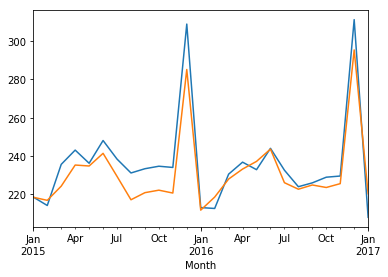

In [88]:
frc_s['Real wage'].loc['01.01.2015':'01.01.2017'].plot(label='predict')
ts['Real wage'].loc['01.01.2015':'01.01.2017'].plot(label='m_wage')

<h1 align="center">3. ARIMA Momdel for wage dataset (55%) </h1>
You need to analyseTS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">energy_consumption.csv</span> in accordance with forecasting scheme (see lecture slide Scheme of TS forecasting with ARIMA) and then build forecast.

**I. Select ARIMA parameters yourself **
Follow to the steps from 2.I. 

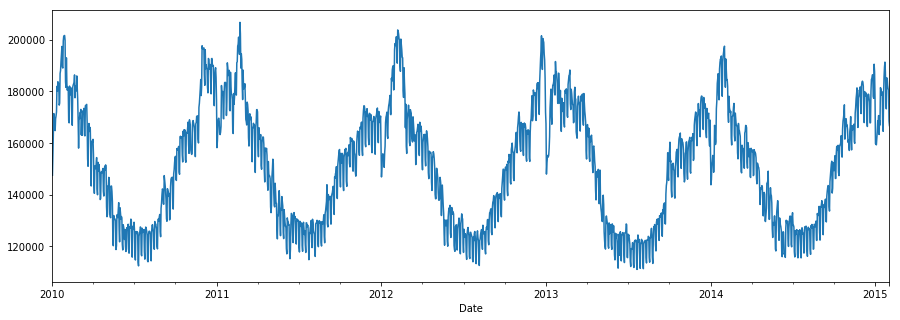

In [4]:
#0)1)
en1=ts_en['EnergyConsump'].loc[:'2015-02-01']
en1.plot(figsize=(15,5))

In [5]:
en1 = en1.to_frame(name='EnergyConsump')

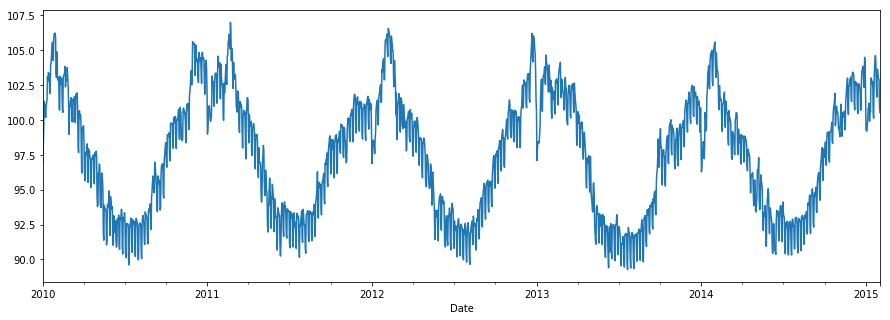

In [6]:
#2)
from copy import deepcopy
en1_boxcox = deepcopy(en1)
en1_boxcox['wage_boxcox'] = stats.boxcox(en1)[0]
en1_boxcox['wage_boxcox'].plot(figsize=(15,5))

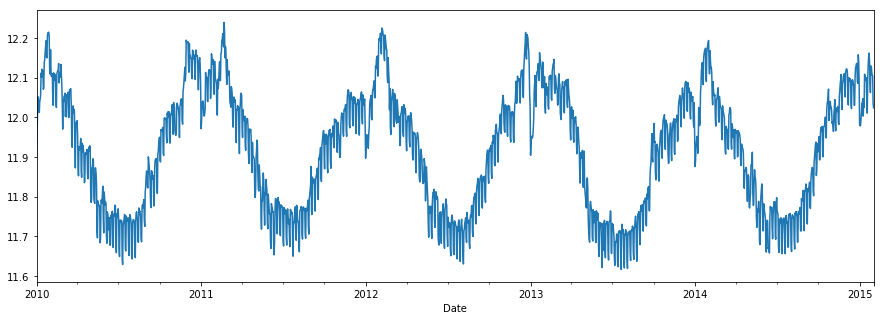

In [7]:
en1_boxcox['wage_boxcox'] = np.log(en1)
en1_boxcox['wage_boxcox'].plot(figsize=(15,5))

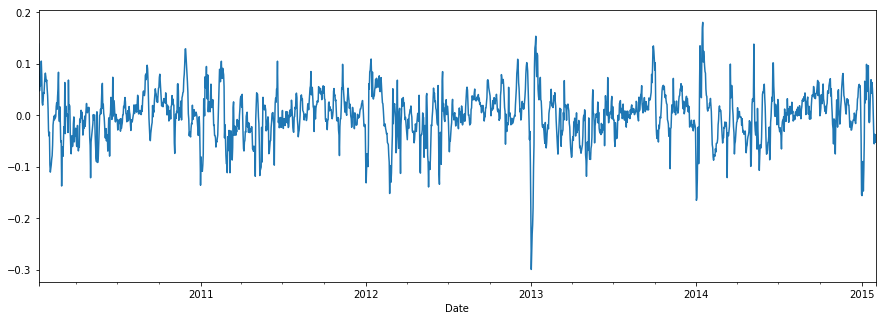

In [8]:
#3)
p = 7
sdiff_en1_boxcox = (en1_boxcox['wage_boxcox'] - en1_boxcox['wage_boxcox'].shift(p))[p:]
sdiff_en1_boxcox.plot(figsize=(15,5))

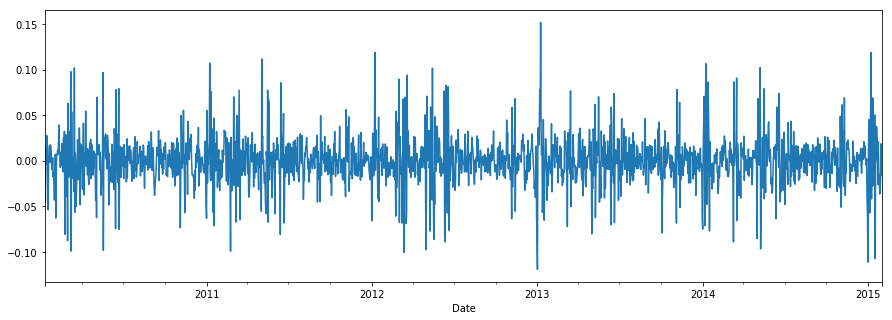

In [9]:
diff_sdiff_en1_boxcox = (sdiff_en1_boxcox  - sdiff_en1_boxcox .shift(1))[1:]
diff_sdiff_en1_boxcox.plot(figsize=(15,5))

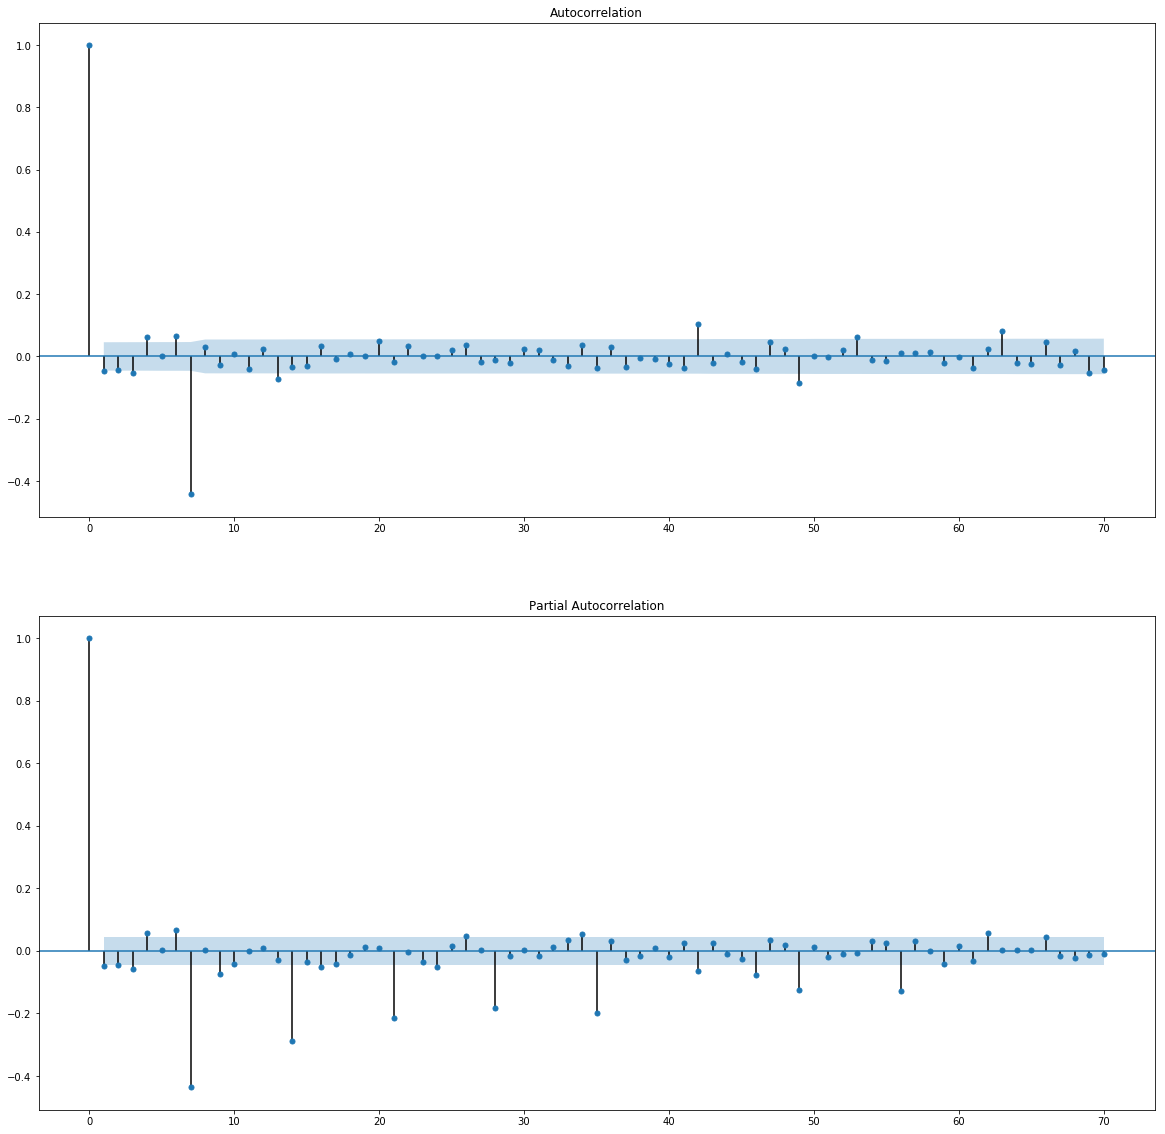

In [10]:
#4)
en2 = diff_sdiff_en1_boxcox
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(en2.values.squeeze(), lags=70, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(en2.values.squeeze(), lags=70, ax=ax2)

5) So we have to chose $p\in\{3,4,6\}$, $q\in\{3,4,6\}$, $Q=1$ and $P=8$.

In [9]:
from statsmodels.tsa import stattools
stat= stattools.kpss(np.array(en2))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.025979, 
pvalue: 0.10 
maximal Lag: 25 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning:

p-value is greater than the indicated p-value



In [10]:
mod_en = sm.tsa.statespace.SARIMAX(en1, trend='n', order=(4,1,6), seasonal_order=(8,1,1,7))
results_en = mod_en.fit()
print(results_en.summary())

C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                 Statespace Model Results                                
Dep. Variable:                     EnergyConsump   No. Observations:                 1858
Model:             SARIMAX(4, 1, 6)x(8, 1, 1, 7)   Log Likelihood              -17720.249
Date:                           Thu, 08 Jun 2017   AIC                          35480.498
Time:                                   18:01:16   BIC                          35591.043
Sample:                               01-01-2010   HQIC                         35521.239
                                    - 02-01-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1624      1.116     -0.146      0.884      -2.350       2.025
ar.L2          0.4804      0.294      1.634

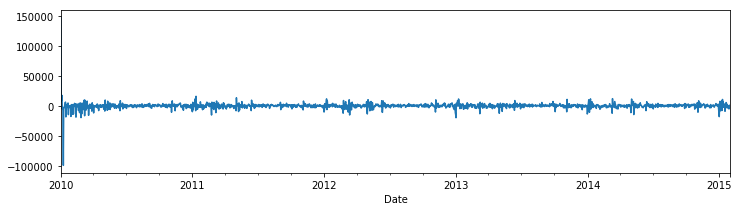

In [11]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
ax = results_en.resid.plot(ax=ax);

In [12]:
# Darbin_Watson statistic
sm.stats.durbin_watson(results_en.resid.values)

1.517312207085532

In [13]:
stat = stats.wilcoxon(results_en.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat[0],stat[1]))

Statistic: 853264.000000
pvalue: 0.66


In [14]:
# Normal test
resid = results_en.resid
stats.normaltest(resid)

NormaltestResult(statistic=2716.9645480735671, pvalue=0.0)

In [15]:
frc_en = results_en.predict('2015-01-01', '2017-01-01', dynamic=False)
print(frc_en)

2015-01-01    177740.196015
2015-01-02    160360.946858
2015-01-03    151749.426154
2015-01-04    159845.874592
2015-01-05    172739.712421
2015-01-06    162067.054559
2015-01-07    164101.247450
2015-01-08    162186.557561
2015-01-09    170965.680519
2015-01-10    158033.624789
2015-01-11    168848.973319
2015-01-12    174719.503636
2015-01-13    182881.749725
2015-01-14    181980.453979
2015-01-15    181042.183285
2015-01-16    176735.723699
2015-01-17    175818.836252
2015-01-18    165594.078007
2015-01-19    176209.098293
2015-01-20    180062.260269
2015-01-21    185226.007365
2015-01-22    188585.567910
2015-01-23    191255.137401
2015-01-24    176297.654782
2015-01-25    175754.763587
2015-01-26    185746.910751
2015-01-27    188493.116601
2015-01-28    187540.072558
2015-01-29    182725.849220
2015-01-30    179680.001535
                  ...      
2016-12-03    231322.642300
2016-12-04    229869.099718
2016-12-05    240308.738991
2016-12-06    241358.578238
2016-12-07    241121

In [16]:
frc_en = frc_en.to_frame(name='EnergyConsump')

In [59]:
ts_en_1=ts_en['EnergyConsump'].to_frame(name='EnergyConsump')

In [23]:
qualityMACAPE(frc_en, ts_en_1.loc['01.01.2015':])[0]

EnergyConsump    0.081969
dtype: float64

**II. Find the best parameters of ARIMA automaticaly**

In [19]:
P_values=[5,8]
Q_values=[1,6]
p_values=[4,6]
q_values=[4,6]
Dd_values=[1,2]
min_aic=10000000
for P in P_values:
    for Q in Q_values:
        for p in p_values:
            for q in q_values:
                for d in Dd_values:
                    for D in Dd_values:
                        print('model '+str((p,d,q,P,D,Q)))
                        try:
                            mod = sm.tsa.statespace.SARIMAX(en1, trend='n', order=(p,d,q), seasonal_order=(P,D,Q,7))
                            results = mod.fit()
                        except Exception:
                            continue
                        if results.aic==np.NaN:
                            continue
                        if results.aic<min_aic:
                            min_aic=results.aic
                            model_min_aic=[p,d,q,P,D,Q]
                

model (4, 1, 4, 5, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 1, 4, 5, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 2, 4, 5, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 2, 4, 5, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 1, 6, 5, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 1, 6, 5, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 2, 6, 5, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 2, 6, 5, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (6, 1, 4, 5, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (6, 1, 4, 5, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (6, 2, 4, 5, 1, 1)
model (6, 2, 4, 5, 2, 1)
model (6, 1, 6, 5, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (6, 1, 6, 5, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (6, 2, 6, 5, 1, 1)
model (6, 2, 6, 5, 2, 1)
model (4, 1, 4, 5, 1, 6)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 1, 4, 5, 2, 6)
model (4, 2, 4, 5, 1, 6)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 2, 4, 5, 2, 6)
model (4, 1, 6, 5, 1, 6)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 1, 6, 5, 2, 6)
model (4, 2, 6, 5, 1, 6)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 2, 6, 5, 2, 6)
model (6, 1, 4, 5, 1, 6)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (6, 1, 4, 5, 2, 6)
model (6, 2, 4, 5, 1, 6)
model (6, 2, 4, 5, 2, 6)
model (6, 1, 6, 5, 1, 6)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (6, 1, 6, 5, 2, 6)
model (6, 2, 6, 5, 1, 6)
model (6, 2, 6, 5, 2, 6)
model (4, 1, 4, 8, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 1, 4, 8, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 2, 4, 8, 1, 1)
model (4, 2, 4, 8, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 1, 6, 8, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 1, 6, 8, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 2, 6, 8, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 2, 6, 8, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (6, 1, 4, 8, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (6, 1, 4, 8, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (6, 2, 4, 8, 1, 1)
model (6, 2, 4, 8, 2, 1)
model (6, 1, 6, 8, 1, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (6, 1, 6, 8, 2, 1)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (6, 2, 6, 8, 1, 1)
model (6, 2, 6, 8, 2, 1)
model (4, 1, 4, 8, 1, 6)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 1, 4, 8, 2, 6)
model (4, 2, 4, 8, 1, 6)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 2, 4, 8, 2, 6)
model (4, 1, 6, 8, 1, 6)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 1, 6, 8, 2, 6)
model (4, 2, 6, 8, 1, 6)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (4, 2, 6, 8, 2, 6)
model (6, 1, 4, 8, 1, 6)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (6, 1, 4, 8, 2, 6)
model (6, 2, 4, 8, 1, 6)
model (6, 2, 4, 8, 2, 6)
model (6, 1, 6, 8, 1, 6)


C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



model (6, 1, 6, 8, 2, 6)
model (6, 2, 6, 8, 1, 6)
model (6, 2, 6, 8, 2, 6)


In [20]:
model_min_aic

[6, 1, 4, 5, 1, 1]

In [21]:
min_aic

35454.474784778431

In [55]:
best_mod = sm.tsa.statespace.SARIMAX(en1, trend='n', order=(6,1,4), seasonal_order=(5,1,1,7))
best_results_en = best_mod.fit()

C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [64]:
frc_en_best = best_results_en.predict('2015-01-01', '2017-01-01', dynamic=False)
print(frc_en_best)

2015-01-01    177757.080316
2015-01-02    160030.025093
2015-01-03    151745.666725
2015-01-04    159046.958348
2015-01-05    172640.104512
2015-01-06    162110.847951
2015-01-07    163395.348366
2015-01-08    161928.116053
2015-01-09    170837.475147
2015-01-10    158373.680072
2015-01-11    168296.121331
2015-01-12    174390.391923
2015-01-13    182864.211365
2015-01-14    182207.679343
2015-01-15    181280.787778
2015-01-16    177061.068918
2015-01-17    175319.459187
2015-01-18    165736.337939
2015-01-19    175807.400375
2015-01-20    179811.676927
2015-01-21    184581.809579
2015-01-22    189256.938995
2015-01-23    190892.903442
2015-01-24    176486.143445
2015-01-25    175282.451123
2015-01-26    185747.919188
2015-01-27    188189.286350
2015-01-28    187611.043108
2015-01-29    183161.427331
2015-01-30    179781.886637
                  ...      
2015-04-28    177708.193383
2015-04-29    177763.500545
2015-04-30    177788.273324
2015-05-01    177723.993649
2015-05-02    169199

In [65]:
frc_en_best = frc_en_best.to_frame(name='EnergyConsump')

In [67]:
qualityMACAPE(frc_en_best, ts_en_1.loc['2015-02-01':])[0]

EnergyConsump    0.08025
dtype: float64

** III. Adding of exogenious variables**

* 1) Try to add in models from 3.I. and 3.II exogenious variables (at least one of Temp1, Temp2, Saturday and Sunday).
* 2) Does it make accuracy of foreacast for period from 01.02.2015 to 01.01.2017 better?

In [32]:
exogs = ts_en[['Temp1', 'Temp2', 'Saturday','Sunday']]
exogs_train = exogs.loc[:'2015-02-01']

In [35]:
ts_en

,Hub,ZSP,EnergyConsump,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
Date,,,,,,,,,,,,,,,,,,,,
2010-01-01,Center,FZSZOE27,147487.171,-17.8,-16.9,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,Center,FZSZOE27,155433.800,-17.8,-20.3,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,Center,FZSZOE27,164140.232,-16.4,-24.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,Center,FZSZOE27,171382.848,-10.2,-15.7,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,Center,FZSZOE27,170188.290,-7.2,-8.8,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,Center,FZSZOE27,168969.315,-8.0,-18.6,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,Center,FZSZOE27,164772.821,-9.7,-19.5,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,Center,FZSZOE27,169338.900,-13.3,-18.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-09,Center,FZSZOE27,170479.031,-15.9,-22.3,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
%%time

mod_ex = sm.tsa.statespace.SARIMAX(en1.loc[:'2015.02.01'], trend='n', order=(6,1,4), seasonal_order=(5,1,1,7), exog=exogs_train)
results_ex = mod_ex.fit()
print(results_ex.summary())

C:\Users\Vazgen\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                 Statespace Model Results                                
Dep. Variable:                     EnergyConsump   No. Observations:                 1858
Model:             SARIMAX(6, 1, 4)x(5, 1, 1, 7)   Log Likelihood              -17136.611
Date:                           Fri, 09 Jun 2017   AIC                          34315.223
Time:                                   19:15:32   BIC                          34431.295
Sample:                               01-01-2010   HQIC                         34358.001
                                    - 02-01-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp1        -72.1399     29.775     -2.423      0.015    -130.498     -13.782
Temp2        -94.0178     27.709     -3.393

In [34]:
exogs

,Temp1,Temp2,Saturday,Sunday
Date,,,,
2010-01-01,-17.8,-16.9,0.0,1.0
2010-01-02,-17.8,-20.3,1.0,0.0
2010-01-03,-16.4,-24.0,0.0,1.0
2010-01-04,-10.2,-15.7,0.0,1.0
2010-01-05,-7.2,-8.8,0.0,1.0
2010-01-06,-8.0,-18.6,0.0,1.0
2010-01-07,-9.7,-19.5,0.0,1.0
2010-01-08,-13.3,-18.0,0.0,1.0
2010-01-09,-15.9,-22.3,1.0,0.0


In [37]:
frc_en_ex=results_ex.predict('2015-02-01', '2015-05-27', dynamic = False, exog = exogs.loc['2015-02-01':'2015-05-26'])

In [43]:
frc_en_ex=frc_en_ex.to_frame(name='EnergyConsump')

In [61]:
qualityMACAPE(ts_en_1,frc_en_ex)[0]['EnergyConsump']

0.071120062551742205

Yes accuracy with exogs is better.